# Introductory Analysis of AV1 Entropy Coding

__By: Kyle Siefring__

In the AV1 video coding format, a new entropy coder was added. An entropy
encoder is responsible for compressing the instructions that allow
reconstructing the video frame.

The advantage of the new entropy coder is that it uses a parallel architecture
capable of decoding more than two possibilities in one step. In comparison,
previous coders used a serial process that decoded in a binary manner. This was
a substantial bottleneck for hardware, which are able to utilize fine-grained
parallelization to a much greater extent than CPUs or GPUs. It's also possible
to write [SIMD](https://www.sciencedirect.com/topics/computer-science/single-instruction-multiple-data)
for this process, so there is also some benefits for CPUs
([example](https://code.videolan.org/videolan/dav1d/-/blob/master/src/x86/msac.asm#L264)).

To take advantage of this parallelism, data must be encoded from an 'alphabet'
of more than 2 'letters' or 'symbol'. The largest supported alphabet size is 16,
which allows processing 4-bit long letters. Each alphabet has an associated
distribution for each letter, $i$, stored and operated on in the form
$1 - CDF_i$ (in [fixed-point arithmetic](https://en.wikipedia.org/wiki/Fixed-point_arithmetic)).
This is an approximate of the frequency that takes spatial locality into account
(unlike the static behaviour of [huffman coding](https://en.wikipedia.org/wiki/Huffman_coding)).
Since this structure for storing distributions is related to the
Cumulative Distribution Function, it will be referred to as a CDF.

CDFs are generally updated whenever a symbol is encoded. It should be noted
that some CDFs have static, hardcoded probabilities, and there is also
functionality to turn off updates over some period of time.

CDF's are not necessarily global over the entire program. Frames can be split
into 'tiles' that have independent CDF 'contexts'. The tiles in the next frame
obtain their contexts from the final state of previous contexts or,
alternatively, reset to the initial CDFs specified in the standard.

In practice, AV1 doesn't take advantage of larger alphabets as much as one
would hope. In this tutorial, we will take a file containing a dump of a video's
symbol data and analyze the performance of the entropy encoder. We won't be
considering any video data that disable updates to CDFs or any of the hardcoded
CDFs.

daala, the experimental codec that AV1's entropy coder is from, has a [design doc (tex)](https://github.com/xiph/daala/blob/694d4ced7e97f349cd4f54dbfc8c8a69982a54e4/doc/design.tex)
that contains more information and backgroud on the entropy coder.

## Getting the Data

[libaom v3.1.0](https://aomedia.googlesource.com/aom/+/refs/tags/v3.1.0)
was used to encode a clip using the following options
``aomenc -o <output>.ivf <input> --profile=0 --cpu-used=1 --threads=2 --tile-columns=2 --end-usage=q --cq-level=43``.
See ``aomenc --help`` for what these options do.

The clip used is a version of ``Netflix_ToddlerFountain_4096x2160_60fps_10bit_420.y4m``
(can be found [here](https://media.xiph.org/video/derf/)) that has been
converted to 8 bits and downsampled to 1080p using ffmpeg.

The encoded video file can be found [here](https://drive.google.com/file/d/1GZ2hx6okLo4Dkh0wKvUHBBK7_lDYDNoL/view?usp=sharing).

To dump symbol data, modifications were made to the decoder in libaom. The
branch containing those changes can be found [here](https://github.com/KyleSiefring/libaom/tree/symbol_dump_1).
Building the encoder
is broken on this branch, so it is necessary to run ``make aomdec`` instead of
just ``make`` to build successfully. The first 600 out of 1200 frames were
decoded using ``../aomdec <input>.ivf -o /dev/null --progress -t 1 --limit=600``.

### Format
The dumped file contains a list of events and data for each event.

Events:
- The initial cdf and some descriptors for the event. Descriptors include:
    - An id to uniquely identify the individual cdf.
    - The function name of the CDF, or a custom name already provided by libaom.$^*$
    - Source file and line number that the symbol first encoded on.$^*$
- Decode a symbol with update.
- Decode a symbol without update (not supported).
- Copy CDFs from one context to another.
- Change the context symbols are currently being written to.

Using these events, we can model the entropy coding process later on.

$^*$ Unfortunately, it might be possible for these to be different for one id
with two different files.

#### Loading The Data In
To load this file faster than would have been possible with regular Python,
[Cython](https://cython.org/) is used. Cython is a modified version of Python
that compiles to C code. The ability to define types of variables and access
C APIs helped significantly when dealing with the very granular loads in this
code.

In [1]:
import pandas as pd
import numpy as np
%load_ext Cython
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats

In [2]:
%%cython

# Need to reimport for cython
import numpy as np
cimport numpy as np
import pandas as pd
# C libraries
from libc.stdio cimport FILE, fopen, fclose, fgetc, fread, feof

# Tree that demonstrates the movement of contexts over a video.
cdef class ContextTree:
    # Starting context that is associated with initial cdfs
    cdef public int root_context
    # dict mapping to children that copy from a given context
    # list of children = dict[parent context]
    cdef public dict children

    def __init__(self):
        self.root_context = 0
        self.children = {self.root_context:[]}

    def chain_contexts(self, parent, child):
        self.children[parent].append(child)
        self.children.setdefault(child, [])

# Read little endian 16-bit unsigned integer
cdef inline int read_u16_le(unsigned char* buf):
    return buf[0] | (buf[1] << 8)

# Read in a string
cdef inline str fread_str(FILE* file, unsigned char* buf):
    fread(buf, 1, 1, file)
    strlen = buf[0]
    fread(buf, 1, strlen, file)
    # Convert to a python string
    return buf[:strlen].decode()

def load_symbol_file(char* filename):
    # Use a buffer. Using python libraries has an annoying amount of gc/ref
    # counting overhead when only reading a few bytes at a time.
    cdef unsigned char buf[255]

    # Open a file with the c api.
    cdef FILE* file = fopen(filename, 'rb')

    # Each row in the dataframe, initialize later
    cdef list cdf_df_rows = []

    # map of context to
    #   map of cdf_id to a bytearray of symbols
    cdef dict symbol_data = {}

    # map of cdf id to the initial cdf probabilities
    cdef dict initial_cdfs = {}

    # Lifecycle of cdf contexts
    cdef context_tree = ContextTree()

    cdef dict current_context = None

    # Cache the current cdf for extra performance
    cdef int cached_cdf_id = -1
    cdef bytearray cached_cdf_symbols = None

    # Loop through each event.
    while True:
        # Read and switch based on event type
        event_type = fgetc(file)
        if event_type == -1:
            # EOF
            break
        elif event_type == 0:
            # initialize defaults cdfs and

            # CDF id needs 2 bytes and the alphabet size requires one byte
            fread(buf, 1, 3, file)
            (cdf_id, alphabet_len) = read_u16_le(buf), buf[2]
            name = fread_str(file, buf)
            src_file = fread_str(file, buf)
            fread(buf, 1, 2, file)
            src_line = read_u16_le(buf)

            # Remove full path from the file
            src_file = src_file[src_file.rfind('/')+1:]
            # Append information for a dataframe
            cdf_df_rows.append(
                [cdf_id, name, src_file, src_line, alphabet_len]
            )

            # Read in the initial CDF
            initial_cdf = np.zeros(alphabet_len, np.uint16)
            for i in range(alphabet_len):
                fread(buf, 1, 2, file)
                initial_cdf[i] = read_u16_le(buf)
            initial_cdfs[cdf_id] = initial_cdf
        elif event_type == 1:
            # read symbol with a context update

            fread(buf, 1, 3, file)
            symbol, cdf_id = buf[0], read_u16_le(buf + 1)
            # Try reusing the cached cdf
            if cdf_id != cached_cdf_id:
                cached_cdf_id = cdf_id
                cached_cdf_symbols = current_context.setdefault(
                    cdf_id,
                    bytearray()
                )
            cached_cdf_symbols.append(symbol)
        elif event_type == 2:
            # read symbol without updating context
            print('Symbols encoded without cdf update not supported')
        elif event_type == 3:
            # copy a previous context into this one

            # Read two bytes for each context identifier
            fread(buf, 1, 4, file)
            parent_context_id = read_u16_le(buf)
            child_context_id = read_u16_le(buf + 2)
            context_tree.chain_contexts(
                parent_context_id, child_context_id
            )
        elif event_type == 4:
            # change the current context

            # read what
            fread(buf, 1, 2, file)
            context_id = read_u16_le(buf)

            # This will probably never reuse a context
            current_context = symbol_data.setdefault(context_id, {})

            # Invalidate the cdf cache
            current_cdf_id = -1
            current_cdf_symbols = None
        else:
            print('Unrecognized event read: %d'% event_type)
            break
    fclose(file)

    for x in symbol_data.values():
        for (a, b) in x.items():
            x[a] = np.array(b, dtype=np.uint8)

    df_cdfs = pd.DataFrame(
        cdf_df_rows,
        columns=['id', 'descriptor', 'src_file', 'line', 'alphabet_len']
    )

    return symbol_data, context_tree, df_cdfs, initial_cdfs

Finally, call the cython function to load our data in.

In [3]:
# Get the following from load_symbol_file
#   (some of these are also documented inside the function)
# symbol_data
#   Map of context to
#       map of cdf_id to symbols
# context_tree
#   Lifecycle of cdf contexts
# df_cdfs
#   A list of basic info on the cdfs
# initial_cdfs
#   Map of cdf id to the initial cdf probabilities

# Call the function for loading in events
start_time = datetime.datetime.now()
symbol_data, context_tree, df_cdfs, initial_cdfs = load_symbol_file(b"/home/kyle/Programming/VideoEncode/libaom/events.bin")
end_time = datetime.datetime.now()
print('duration', end_time - start_time)

duration 0:00:19.793273


#### Assessing the Extent of the Problem: Part 1
Now, we can examine what size the CDFs are using a bar chart. What would be more
useful is to know is how many are symbols are encoded for each alphabet size.
This will be done later on.

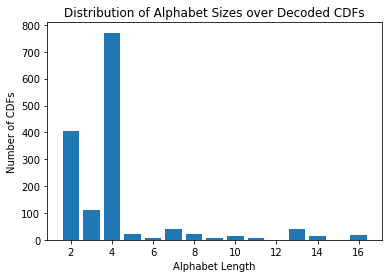

In [4]:
# Count cdfs alphabets sizes from binary to 16 letters
plt.bar(range(2,16+1), np.bincount(df_cdfs.alphabet_len.to_numpy())[2:16+1])
plt.ylabel('Number of CDFs')
plt.xlabel('Alphabet Length')
plt.title('Distribution of Alphabet Sizes over Decoded CDFs')
plt.show()

It seems that the majority of CDFs are 2-4 bits, which is unfortunate.

## Processing the Data

We want to run a loop to process and examine the symbol data that we have read.
There are a few helper methods and classes that will be useful for doing this.
Once again, we are going to use Cython to speed up some of this.

We have two important functions here:
- One function, `CDFState.update`, updates or 'adapts' the CDF based on a
symbol that has been decoded.
- The other function, `CDFState.calc_symbol_cost`, takes the probabilities and
computes approximately how many bits are needed for that symbol. This is a
floating point value; it's very much possible to read a fraction of a bit.

In [5]:
%%cython

import numpy as np
cimport numpy as np

# Holds everything needed to model the entropy encoding process over one
# context. The count held here is reset whenever a new context is created.
cdef class CDFState:
    # CDF data
    cdef public np.ndarray cdf

    # Number of symbols encoded so far. Defaults to 0.
    cdef public int count

    # Minimum probability possible.
    # Not actually a minimum, since it is added in between each probability.
    # Hard coded as 4 in the standard
    cdef int min_prob

    # Precalculated log of the actual sum of the integer representation
    # of each probability (aka. includes the minimun probability)
    cdef float base_prob

    def __init__(self, cdf, count = 0):
        self.cdf = cdf.copy()
        self.count = count

        self.min_prob = 4
        self.base_prob = np.log2((1<<15) + self.min_prob*len(cdf))

    # See https://github.com/xiph/rav1e/blob/c5bc3402475bf6b6190/src/ec.rs#L894
    def update(self, int symbol):
        cdef np.ndarray[np.uint16_t, ndim=1] cdf = self.cdf
        cdef int nsymbols = len(cdf)
        cdef int rate = 3 + min((nsymbols + 1) >> 1, 2)

        # Adapt quickly with few symbols encoded.
        rate += (self.count >> 4)
        # Increment count up to 32
        self.count += 1 - (self.count >> 5)

        # Adapt the probabilities based on the selected probability
        for i in range(nsymbols):
            if i >= symbol:
                cdf[i] -= cdf[i] >> rate
            else:
                cdf[i] += ((1 << 15) - cdf[i]) >> rate

    # Approximate the cost to encode a symbol for a symbol using the current
    # cdf.
    def calc_symbol_cost(self, int symbol):
        cdef np.ndarray[np.uint16_t, ndim=1] cdf = self.cdf
        # Get the probability for symbol
        #   We want the difference between two cdfs for that.
        #   For symbol 0, this is our largest supported value (1<<15)
        a = 1<<15
        if symbol != 0:
            a = int(cdf[symbol - 1])
        diff = a - cdf[symbol]

        # The cost to encode a bit is log2(1/prob) = log2(1) - log(prob)
        # In our fixed point arithmetic implementation, this is
        # log((1<<15) + some stuff) - log(fixed point prob)
        #
        #   Also, convert to float before log for a little extra speedup
        return self.base_prob - np.log2(float(diff + self.min_prob))

Regardless of what the entropy coder is doing, its useful to know how many of
each symbol is used by a given CDF.

In [6]:
# Used to count the number of symbols used over multiple arrays.
# This is useful since every context has a separate array for a CDF's symbols.
class SymbolCounters:
    def __init__(self, size):
        self.counts = np.zeros(size)

    # Count the symbols in a array of symbols
    def count_symbols(self, symbols):
        self.counts += np.bincount(symbols, minlength=len(self.counts))

    def __repr__(self):
        return self.counts.__repr__()
    def __str__(self):
        return self.counts.__str__()

We can now start processing the symbol data and gathering stat. We are trying
to closely emulate the CDF process here.

Among the stats gathered for each CDF we have:
- $Bits$: The number of bits required for all the symbols.
- $\#\ Symbols$ (Number of Symbols): Total number of symbols associated with a
cdf.
- $\frac{Bits}{\# Symbol}$ (Bits per Symbol): Simply the average number of bits
required for each symbol.
- Symbol Counts: Counts how many of each symbol has been used for a CDF.
- $\frac{Bits}{\#\ Symbols * \log_2(Alphabet\ Length)}$: This ends up being
useful. Without using an entropy coder, a symbol from an Alphabet of length $L$
can always be encoded in $\log_2(L)$ bits. This means that a value of the variable
nearing 1 (or worse, above!) indicates a symbol that isn't benefiting much from
the entropy coder.

Plenty of other statistics might be useful; for example: it could be
useful to compare
[entropy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.entropy.html)
to the bits used to assess whether a symbol is benefiting from locality.

In [7]:
start_time = datetime.datetime.now()

# Copy the existing cdf data from an old table
#   (Personal preference when working in jupyter)
df_stats = df_cdfs.copy()
df_stats['bits'] = 0
df_stats['num_symbols'] = 0
df_stats['bits_per_symb'] = np.nan
df_stats['symb_counts'] = None

# Set up the initial cdfs as a context.
context_end_cdfs = {context_tree.root_context: initial_cdfs}

# Iterate through each context, yielding a parent and child context.
def iter_contexts(tree):
    path = [tree.root_context]
    while len(path) != 0:
        parent = path.pop()
        for child in tree.children[parent]:
            yield parent, child
            path.append(child)

# There is an outer loop for each cdf and inner loop that goes over
#   each context
for cdf_id, initial_cdf in initial_cdfs.items():
    num_symbols = 0
    cost = 0 # total cost in bits
    count = SymbolCounters(len(initial_cdf))

    for parent_context, child_context in iter_contexts(context_tree):
        # Carry forward cdfs from the parent context
        cdf = context_end_cdfs[parent_context][cdf_id]
        # The cdf might not have any symbols, but it can still have cdfs
        # inherited from it
        context_end_cdfs.setdefault(child_context, {})[cdf_id] = cdf
        # Load the dict of cdf_ids to symbol data for this context
        context = symbol_data[child_context]

        # Sometimes a context will be empty and uninitialized.
        if context is None:
            continue

        arr = context.get(cdf_id)
        if arr is None:
            continue
        # Count all of the symbols
        num_symbols += len(arr)
        count.count_symbols(arr)

        # Set up our CDFState with the loaded cdf.
        #   This state contains a counter that tweaks the adaption rate at the
        #   start.
        cdf_state = CDFState(cdf)

        # Get the bits used and update the cdfs for every symbol
        for symbol in arr:
            cost += cdf_state.calc_symbol_cost(symbol)
            cdf_state.update(symbol)

        # Save the final cdf state for future contexts to carry on from
        context_end_cdfs[child_context][cdf_id] = cdf_state.cdf
    if num_symbols == 0:
        continue

    # Store statistics in the cdf_id's row
    row = df_stats[df_stats.id == cdf_id].index[0]
    df_stats.at[row, 'num_symbols'] = num_symbols
    df_stats.at[row, 'bits'] = cost
    df_stats.at[row, 'bits_per_symb'] = cost/num_symbols
    # Store away the counts for reasons TM
    df_stats.at[row, 'symb_counts'] = count

df_stats['bits_per_symb_over_lg_alp_len'] =\
    df_stats.bits_per_symb / np.log2(df_stats.alphabet_len)

end_time = datetime.datetime.now()
print('duration', end_time - start_time)

# Returns a version of the data frame with more readable names.
# The normal names are useful for indexing, though.
def tidy(df):
    pd.options.display.float_format = '{:,.3f}'.format
    return df.rename(
        columns={
            'descriptor': 'Descriptor', 'line': 'Line', 'src_file': 'Src File',
            'alphabet_len': 'Alphabet Length', 'bits': 'Bits',
            'num_symbols': 'Num Symbols', 'bits_per_symb': 'Bits / Symbol',
            'symb_counts': 'Symbol Counts',
            'bits_per_symb_over_lg_alp_len': '(Bits / Symbol) / log(len(Alp.))'
        }
    )

tidy(df_stats.sort_values('bits', ascending=False))

duration 0:04:21.025687


,id,Descriptor,Src File,Line,Alphabet Length,Bits,Num Symbols,Bits / Symbol,Symbol Counts,(Bits / Symbol) / log(len(Alp.))
821,3046,read_coeffs_reverse_2d,decodetxb.c,72,4,8163922,7227032,1.130,[4181007. 2858190. 153434. 34401.],0.565
820,3045,read_coeffs_reverse_2d,decodetxb.c,72,4,6061286,10515505,0.576,[9.113785e+06 1.385429e+06 1.149100e+04 4.8000...,0.288
895,3031,read_coeffs_reverse_2d,decodetxb.c,72,4,4031363,2988720,1.349,[1454813. 1302835. 185517. 45555.],0.674
608,3624,av1_read_tx_type,decodemv.c,652,16,3699215,1093206,3.384,[ 4223. 5300. 2227. 69144. 26385. 5900...,0.846
10,4004,read_filter_intra_mode_info,decodemv.c,614,5,3190683,1594553,2.001,[521710. 345616. 95313. 254895. 377019.],0.862
...,...,...,...,...,...,...,...,...,...,...
1362,3019,read_coeffs_reverse,decodetxb.c,96,4,0,1,0.654,[1. 0. 0. 0.],0.327
1453,3161,read_coeffs_reverse_2d,decodetxb.c,72,4,0,11,0.047,[11. 0. 0. 0.],0.023
1332,3386,av1_read_coeffs_txb,decodetxb.c,253,3,0,1,0.127,[1. 0. 0.],0.080
1283,3419,av1_read_coeffs_txb,decodetxb.c,253,3,0,4,0.053,[4. 0. 0.],0.033


## Analysis
#### Assessing the Extent of the Problem: Part 2
As promised earlier, we will create a new plot of alphabet lengths.
This one is weighted by the number of symbols encoded to get a more realistic
picture of the overhead incurred by smaller symbols.

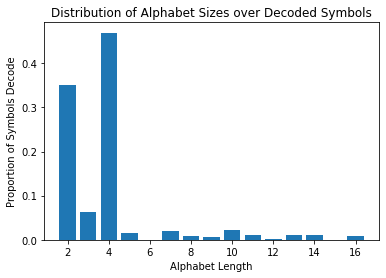

In [8]:
# Count cdfs alphabets sizes from binary to 16 letters
counts = np.bincount(
    df_stats.alphabet_len,
    weights=df_stats.num_symbols
)[2:16+1]

# Plot the proportion this time. There are too many symbols for the numbers
#   to be any more meaningful than a percent.
plt.bar(range(2,16+1), counts/counts.sum())
plt.ylabel('Proportion of Symbols Decode')
plt.xlabel('Alphabet Length')
plt.title('Distribution of Alphabet Sizes over Decoded Symbols')
plt.show()

This is even worse than before $-$ the smaller symbols take up an even bigger
portion of symbols compared to unique cdfs.

### Aggregated Statistics
In some cases, there seem to be multiple different CDFs for the same line of
the decoder source. Since there are over 1000 different CDFs, we should combine
these for the initial analysis.

In [9]:
# Combine the entries that share file, line, and function
group_stats = df_stats.groupby(['descriptor', 'src_file', 'line'])
combined = group_stats.agg(
    # Count the number of different CDFs
    count = ('id', 'count'),
    # Combine bits and the number of symbols
    bits = ('bits', 'sum'),
    num_symbols = ('num_symbols', 'sum'),
    # Implement weighted average using the number of symbols for each
    bits_per_symb_over_lg_alp_len = (
            'bits_per_symb_over_lg_alp_len',
            lambda x: np.average(x, weights=df_stats.loc[x.index, 'num_symbols'])
        )
).reset_index()
tidy(combined.sort_values(by='bits', ascending=False))

,Descriptor,Src File,Line,count,Bits,Num Symbols,(Bits / Symbol) / log(len(Alp.))
24,read_coeffs_reverse_2d,decodetxb.c,72,363,71228394,64343763,0.554
22,read_coeffs_reverse,decodetxb.c,96,138,9618261,9678122,0.497
57,read_partition,decodeframe.c,1295,20,6183295,4304588,0.441
12,av1_read_tx_type,decodemv.c,652,6,5282366,1746597,0.782
25,read_coeffs_reverse_2d,decodetxb.c,77,137,4779553,2984232,0.801
...,...,...,...,...,...,...,...
17,loop_restoration_read_sb_coeffs,decodeframe.c,1718,1,2854,3440,0.524
58,read_ref_frames,decodemv.c,957,3,1033,2099,0.493
59,read_ref_frames,decodemv.c,962,3,713,1127,0.634
60,read_ref_frames,decodemv.c,964,3,442,913,0.485


Let's look for group of CDFs with concerning values of
$\frac{Bits}{\#\ Symbols * \log_2(Alphabet\ Length)}$.

In [10]:
# Show the highest entries for the metric we are using
tidy(
    combined.sort_values(
        by='bits_per_symb_over_lg_alp_len', ascending=False
    )[0:10]
)

,Descriptor,Src File,Line,count,Bits,Num Symbols,(Bits / Symbol) / log(len(Alp.))
51,read_mv_component,decodemv.c,845,2,1828306,1837949,0.995
54,read_mv_component,decodemv.c,858,18,2918517,2971692,0.982
33,read_inter_block_mode_info,decodemv.c,1393,7,637320,650564,0.980
35,read_inter_block_mode_info,decodemv.c,1430,6,313359,325193,0.964
27,read_delta_qindex,decodemv.c,95,1,11657,6074,0.960
11,av1_read_coeffs_txb,decodetxb.c,288,12,3695723,3975635,0.930
66,read_ref_frames,decodemv.c,1003,3,1820503,1972238,0.923
32,read_inter_block_mode_info,decodemv.c,1382,3,1684071,1867023,0.902
40,read_inter_mode,decodemv.c,180,6,1777743,1972238,0.901
53,read_mv_component,decodemv.c,852,2,692471,798075,0.868


Our first two values are from the same function, `read_mv_component`. Let's
look at the libaom source code to see what is being decoded on line 845
and 858.

[Source Link](https://github.com/KyleSiefring/libaom/blob/5080acdbe8c621deecc9874d3fc99337f05a679b/av1/decoder/decodemv.c#L842-L898)
```c
842|static int read_mv_component(aom_reader *r, nmv_component *mvcomp,
843|                             int use_subpel, int usehp) {
844|  int mag, d, fr, hp;
845|  const int sign = aom_read_symbol(r, mvcomp->sign_cdf, 2, ACCT_STR);
846|  const int mv_class =
847|      aom_read_symbol(r, mvcomp->classes_cdf, MV_CLASSES, ACCT_STR);
848|  const int class0 = mv_class == MV_CLASS_0;
849|
850|  // Integer part
851|  if (class0) {
852|    d = aom_read_symbol(r, mvcomp->class0_cdf, CLASS0_SIZE, ACCT_STR);
853|    mag = 0;
854|  } else {
855|    const int n = mv_class + CLASS0_BITS - 1;  // number of bits
856|    d = 0;
857|    for (int i = 0; i < n; ++i)
858|      d |= aom_read_symbol(r, mvcomp->bits_cdf[i], 2, ACCT_STR) << i;
859|    mag = CLASS0_SIZE << (mv_class + 2);
860|  }
861|
862|  if (use_subpel) {
863|    // Fractional part
864|    fr = aom_read_symbol(r, class0 ? mvcomp->class0_fp_cdf[d] : mvcomp->fp_cdf,
865|                         MV_FP_SIZE, ACCT_STR);
866|
867|    // High precision part (if hp is not used, the default value of the hp is 1)
868|    hp = usehp ? aom_read_symbol(
869|                     r, class0 ? mvcomp->class0_hp_cdf : mvcomp->hp_cdf, 2,
870|                     ACCT_STR)
871|               : 1;
872|  } else {
873|    fr = 3;
874|    hp = 1;
875|  }
876|
877|  // Result
878|  mag += ((d << 3) | (fr << 1) | hp) + 1;
879|  return sign ? -mag : mag;
880|}
881|
882|static INLINE void read_mv(aom_reader *r, MV *mv, const MV *ref,
883|                           nmv_context *ctx, MvSubpelPrecision precision) {
884|  MV diff = kZeroMv;
885|  const MV_JOINT_TYPE joint_type =
886|      (MV_JOINT_TYPE)aom_read_symbol(r, ctx->joints_cdf, MV_JOINTS, ACCT_STR);
887|
888|  if (mv_joint_vertical(joint_type))
889|    diff.row = read_mv_component(r, &ctx->comps[0], precision > MV_SUBPEL_NONE,
890|                                 precision > MV_SUBPEL_LOW_PRECISION);
891|
892|  if (mv_joint_horizontal(joint_type))
893|    diff.col = read_mv_component(r, &ctx->comps[1], precision > MV_SUBPEL_NONE,
894|                                 precision > MV_SUBPEL_LOW_PRECISION);
895|
896|  mv->row = ref->row + diff.row;
897|  mv->col = ref->col + diff.col;
898|}
```

Line 845 encodes the sign of a [motion vector](https://en.wikipedia.org/wiki/Motion_vector) and line 858 encodes
individual bits. The CDFs also seem to be split between of the horizontal and
vertical components. It makes sense that both of these are close to random
given that the highest set bit is based on `mv_class`.

### Motion Vector Bit Coding

Let's focus on the motion vector bit CDFs. It would be interesting to know if
there are cases
where the entropy coder does a very good job of modeling the behaviour.
Let's start by looking at the individual statistics for each of our
motion vector bit CDFs.

In [11]:
# Select all the mv bit cdfs
mv_bits_line = 858
mv_bits_stats = df_stats[
    df_stats.descriptor.str.match('read_mv') & (df_stats.line == mv_bits_line)
]
tidy(mv_bits_stats[['id', 'bits', 'num_symbols', 'bits_per_symb_over_lg_alp_len']])

,id,Bits,Num Symbols,(Bits / Symbol) / log(len(Alp.))
616,4064,499259,505830,0.987
643,4065,390838,393448,0.993
644,4066,283242,287289,0.986
645,4082,527208,534044,0.987
646,4083,384871,388316,0.991
647,4084,252527,259398,0.974
648,4085,153892,155972,0.987
693,4086,75597,78578,0.962
703,4067,180782,183101,0.987
704,4068,83500,88413,0.944


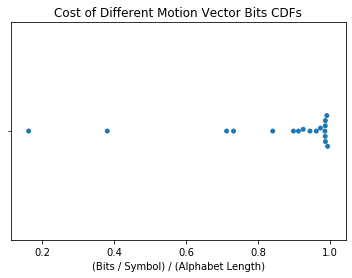

In [12]:
# Plot out the metric for each of the stats in a swarm plot.
#   This will allow use to better see multiple CDF coalesced in proximity.
sns.swarmplot(x=mv_bits_stats.bits_per_symb_over_lg_alp_len)
plt.title('Cost of Different Motion Vector Bits CDFs')
plt.xlabel('(Bits / Symbol) / (Alphabet Length)')
plt.show()

There does indeed seem to be some variation among the CDFs. This doesn't mean
that the CDFs with higher costs are bad. It's possible that all the CDFs would
perform well with a different test clip, or they perform well over segments of
the video. Both of these are analysis that would be valuable, but for now we
should try to get a good statistical verification that these CDFs aren't
modeling a random 50/50 split.

#### Hypothesis Testing

The previous table indicates that there probably enough symbols on each
individual CDF to perform some form of hypothesis testing. The most basic test
would be a [one-proportion test](https://en.wikipedia.org/wiki/Binomial_distribution#Normal_approximation).
With this test, we can test a hypothesis of the true proportion not being equal
to some value.
In our case, we want to test against a value of 0.5. When the null hypothesis
(p = 0.5) is rejected, then there is justification to believe the symbol data
isn't split between two values.

Unfortunately, our analysis will be a little tainted due to the samples not
being completely independent (which is required for the test) of each other.
The concern
is that previous encoder decisions will impact future ones. The good news is
that there is reason to believe that the motion vectors reasonably independent;
since motion vectors point to a block of pixels for the decoder to reference,
it would be expensive for the encoder to choose a vector based heavily on
previous vectors and not the source material$^*$.

Everything being said, it should be okay, but we should be cautious. In this
situation, it makes sense to dump a confidence interval of the proportion using
a binomial model (the same used for the test). This will help prevent us from
going astray by contextualizing the hypothesis test.

$^*$ I want to note that decoded motion vectors are generally offset by
previous motion vectors. This will make the vectors more dependant, but the
point is that we will _probably_ have a representative sample of vectors for
an ideal set of encoder decisions.

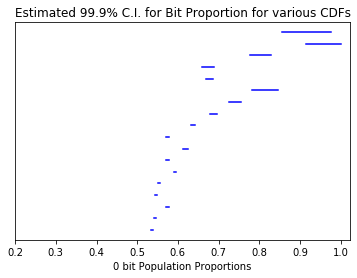

,id,(Bits / Symbol) / log(len(Alp.)),"H0: 0 Bit Proportion(p) = 0.5, est p-value"
616,4064,0.987,2.47E-323
643,4065,0.993,1.98E-323
644,4066,0.986,1.98E-323
645,4082,0.987,2.47E-323
646,4083,0.991,1.98E-323
647,4084,0.974,1.48E-323
648,4085,0.987,9.88E-324
693,4086,0.962,9.88E-324
703,4067,0.987,1.48E-323
704,4068,0.944,9.88E-324


In [13]:
# Test our hypothesis on an individual row.
def add_hypothesis(row):
    counts = row.symb_counts.counts
    n = row.num_symbols
    p_0bit = counts[0] / n
    row['CI'] = np.divide(
        scipy.stats.binom.interval(alpha=0.999, n=n, p=p_0bit), n
    )
    row['H0: 0 Bit Proportion(p) = 0.5, est p-value'] = "{:.2E}".format(
        scipy.stats.binom_test(p_0bit, n, p=0.5)
    )
    return row

# run hypothesis testing on all rows
Hypothesis_table = mv_bits_stats.apply(add_hypothesis, axis=1)

# Render confidence intervals
for (y, ci) in enumerate(hypothesis_table.CI):
    plt.plot(ci, (y,y), color='blue')
plt.yticks([])
plt.xticks(np.arange(0.2,1.01,.1))
plt.xlabel('0 bit Population Proportions')
plt.title('Estimated 99.9% C.I. for Bit Proportion for various CDFs')
plt.show()

tidy(hypothesis_table[[
    'id', 'bits_per_symb_over_lg_alp_len',
    'H0: 0 Bit Proportion(p) = 0.5, est p-value',
]])

All$^*$ of our p-values came back as very low. Assuming whatever amount of
dependence in our data hasn't completely broken analysis, we can safely reject
the null hypothesis that the 0 and 1 bits are split evenly split for our CDFs.

The plot of confidence intervals tells an even more interesting story $-$ it
seems that 0 bits are more common across all CDFs. This provides a bit more
support for our rejecting of the null hypothesises.

$^*$ Since we are testing hypothesis for each CDF, we have to be somewhat weary
of [p hacking](https://fivethirtyeight.com/features/science-isnt-broken).

### Conclusion

It does seem that motion vectors are deriving some benefit from the entropy
coder. The real question is if we can find something better than the current
implementation. This will require a more data to work with (multiple clips),
and additional forms of analysis. Notably, more video clips will provide
independent data that can be used for different hypothesis tests.

Finally, the encoder also will make decisions based on the new implementation,
so we will want to plug any new models in the encoder and measure file size.

Useful Resources:
- [AV1 spec](https://aomediacodec.github.io/av1-spec/av1-spec.pdf)
- [libaom source](https://aomedia.googlesource.com/aom/)